Run on Mac. 

Using the same PSF measurements as in star_profiles_5-output_star_profile_fits-decals_ngc_dr9.ipynb, but fitting with Moffat profile instead of polynomial

In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack, hstack
import fitsio
from astropy.io import fits

In [2]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [3]:
from scipy.optimize import curve_fit

def get_frac_moffat(r, alpha, beta):
    """
    Calculate the fraction of light within radius r of a Moffat profile.
    """    
    frac = 1 - alpha**(2*(beta-1))*(alpha**2 + r**2)**(1-beta)
    return(frac)

def get_sb_moffat(r, alpha, beta):
    """
    Calculate the surface brightness of light at radius r of a Moffat profile.
    The integral (i.e., total flux) is unity by definition.
    """
    i = (beta-1)/(np.pi * alpha**2)*(1 + (r/alpha)**2)**(-beta)
    return i

def get_sb_double_moffat(r, alpha1, beta1, alpha2, beta2, frac1):
    """
    Calculate the surface brightness of light at radius r of the sum of two Moffat profiles.
    The integral (i.e., total flux) ais unity by definition.
    """
    i = frac1 * (beta1-1)/(np.pi * alpha1**2)*(1 + (r/alpha1)**2)**(-beta1) \
        + (1-frac1) * (beta2-1)/(np.pi * alpha2**2)*(1 + (r/alpha2)**2)**(-beta2)
    return i

get_sb_double_moffat_log = lambda r, alpha1, beta1, alpha2, beta2, frac1: \
    np.log10(get_sb_double_moffat(r, alpha1, beta1, alpha2, beta2, frac1))

In [21]:
rlimits = {}
rlimits['g'] = 1, 5, 9, 20, 80
rlimits['r'] = 1, 5, 9, 20, 80
rlimits['z'] = 1, 5, 9, 20, 80

field = 'south'
region_name = 'decals_ngc'

ls_mag_bins = [10.5, 11.75, 13.0, 14.25, 15.5]
ls_mag_bright = 6.5

--------------------------------------------------------------------------------------
south decals_ngc g-band
alpha1, beta1, alpha2, beta2, frac1:
[ 0.05349673  2.09073567 10.35919688  1.0000464   0.81780474]


/Users/rongpu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in log10


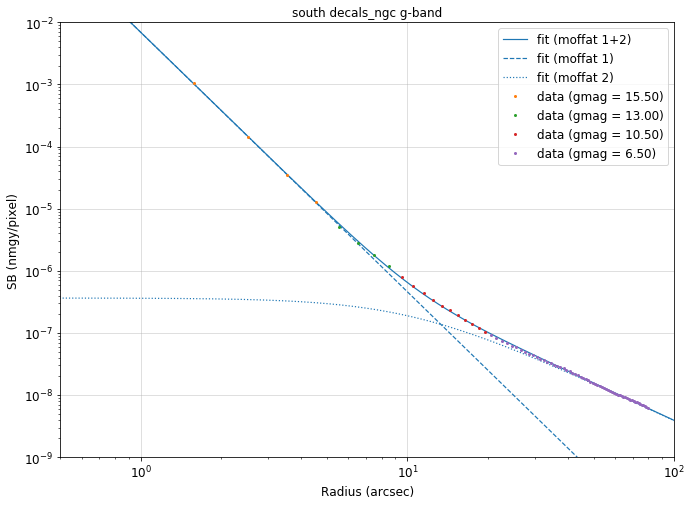

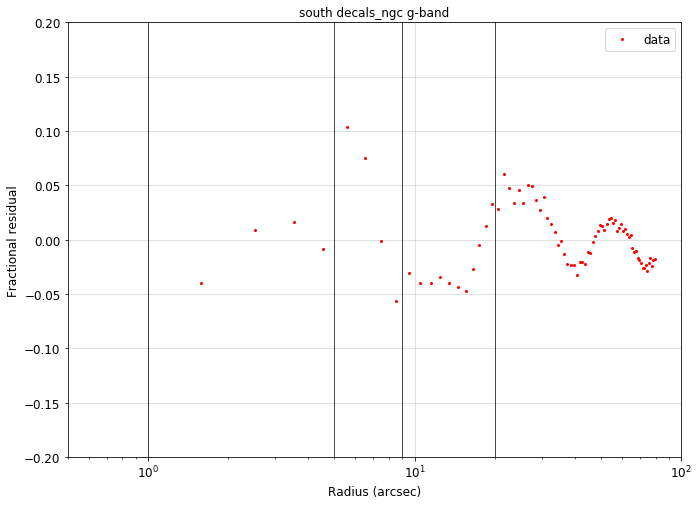

--------------------------------------------------------------------------------------
south decals_ngc r-band
alpha1, beta1, alpha2, beta2, frac1:
[ 0.03081147  1.97627165 14.21206152  1.07874043  0.99991133]


In [ ]:
for band in ['g', 'r', 'z']:
    
    print('--------------------------------------------------------------------------------------')
    print('{} {} {}-band'.format(field, region_name, band))
    
    if (field=='north') and ((band=='g') or (band=='r')):
        pixscale = 0.454
    else:
        pixscale = 0.262

    r1, r2, r3, r4, rmax = rlimits[band]

    ##############################################################################

    profile = Table.read('../data/average_profiles_{}_{}_{}.txt'.format(field, region_name, band), format='ascii.commented_header')
    indiv = Table.read('../data/individual_profiles_{}_{}_{}.fits'.format(field, region_name, band))

    profile_bright = Table.read('../data/average_profiles_{}_{}_{}-bright.txt'.format(field, region_name, band), format='ascii.commented_header')
    indiv_bright = Table.read('../data/individual_profiles_{}_{}_{}-bright.fits'.format(field, region_name, band))

    # stitch together the profiles of two magnitude bins
    index = 4
    # normalize to the flux of a 22.5 mag star per pixel
    norm = 10**((ls_mag_bins[index]-22.5)/2.5) * pixscale**2
    x = profile['radius_{}_{:.2f}'.format(band, ls_mag_bins[index])]
    y = norm * profile['flux_{}_{:.2f}'.format(band, ls_mag_bins[index])]
    mask = (x>r1) & (x<r2)
    xdata = x[mask]
    ydata = y[mask]

    index = 2
    # normalize to the flux of a 22.5 mag star per pixel
    norm = 10**((ls_mag_bins[index]-22.5)/2.5) * pixscale**2
    x = profile['radius_{}_{:.2f}'.format(band, ls_mag_bins[index])]
    y = norm * profile['flux_{}_{:.2f}'.format(band, ls_mag_bins[index])]
    mask = (x>=r2) & (x<r3)
    xdata = np.concatenate((xdata, x[mask]))
    ydata = np.concatenate((ydata, y[mask]))

    index = 0
    # normalize to the flux of a 22.5 mag star per pixel
    norm = 10**((ls_mag_bins[index]-22.5)/2.5) * pixscale**2
    x = profile['radius_{}_{:.2f}'.format(band, ls_mag_bins[index])]
    y = norm * profile['flux_{}_{:.2f}'.format(band, ls_mag_bins[index])]
    mask = (x>=r3) & (x<r4)
    xdata = np.concatenate((xdata, x[mask]))
    ydata = np.concatenate((ydata, y[mask]))

    # normalize to the flux of a 22.5 mag star per pixel
    norm = 10**((ls_mag_bright-22.5)/2.5) * pixscale**2
    x = profile_bright['radius_{}_{:.2f}'.format(band, ls_mag_bright)]
    y = norm * profile_bright['flux_{}_{:.2f}'.format(band, ls_mag_bright)]
    mask = (x>=r4) & (x<rmax)
    xdata = np.concatenate((xdata, x[mask]))
    ydata = np.concatenate((ydata, y[mask]))

    mask1 = (xdata>r1) & (xdata<r2)
    mask2 = (xdata>=r2) & (xdata<r3)
    mask3 = (xdata>=r3) & (xdata<r4)
    mask4 = (xdata>=r4) & (xdata<rmax)

    ######################## Moffat fit ##########################################

    popt, _ = curve_fit(get_sb_double_moffat_log, xdata, np.log10(ydata*pixscale**2), p0=[1, 2, 7, 1, 0.99],
                           maxfev=int(1e5), bounds=(1e-7, (50, 50, 50, 50, 1)))
    if popt[4]<0.5:
        popt[0], popt[1], popt[2], popt[3] = popt[2], popt[3], popt[0], popt[1]
        popt[4] = 1 - popt[4]
    print('alpha1, beta1, alpha2, beta2, frac1:')
    print(popt)

    xplot = np.logspace(-1, 3, 2000)
    yplot = get_sb_double_moffat(xplot, *popt)/pixscale**2
    yfit = get_sb_double_moffat(xdata, *popt)/pixscale**2
    yplot1 = popt[4] * get_sb_moffat(xplot, popt[0], popt[1])/pixscale**2
    yplot2 = (1-popt[4]) * get_sb_moffat(xplot, popt[2], popt[3])/pixscale**2

    ##############################################################################

    plt.figure(figsize=(11, 8))
    plt.loglog(xplot, yplot, 'C0-', lw=1.2, alpha=1., label='fit (moffat 1+2)')
    plt.loglog(xplot, yplot1, 'C0--', lw=1.2, alpha=1., label='fit (moffat 1)')
    plt.loglog(xplot, yplot2, 'C0:', lw=1.2, alpha=1., label='fit (moffat 2)')
    plt.loglog(xdata[mask1], ydata[mask1], 'C1.', lw=1.2, alpha=1., ms=4.,
               label='data ({}mag = {:.2f})'.format(band, ls_mag_bins[4]))
    plt.loglog(xdata[mask2], ydata[mask2], 'C2.', lw=1.2, alpha=1., ms=4.,
               label='data ({}mag = {:.2f})'.format(band, ls_mag_bins[2]))
    plt.loglog(xdata[mask3], ydata[mask3], 'C3.', lw=1.2, alpha=1., ms=4.,
               label='data ({}mag = {:.2f})'.format(band, ls_mag_bins[0]))
    plt.loglog(xdata[mask4], ydata[mask4], 'C4.', lw=1.2, alpha=1., ms=4.,
               label='data ({}mag = {:.2f})'.format(band, ls_mag_bright))
    plt.title('{} {} {}-band'.format(field, region_name, band))
    plt.axis([0.5, 100, 1e-9, 1e-2])
    plt.grid(alpha=0.5)
    plt.xlabel('Radius (arcsec)')
    plt.ylabel('SB (nmgy/pixel)')
    plt.legend()
    plt.show()

    plt.figure(figsize=(11, 8))
    plt.semilogx(xdata, (yfit-ydata)/ydata, '.', lw=1.2, alpha=1., ms=4.,
               label='data', c='r')
    plt.title('{} {} {}-band'.format(field, region_name, band))
    plt.axis([0.5, 100, -0.2, 0.2])
    plt.grid(alpha=0.5)
    plt.xlabel('Radius (arcsec)')
    plt.ylabel('Fractional residual')
    plt.axvline(r1, lw=0.7, color='k')
    plt.axvline(r2, lw=0.7, color='k')
    plt.axvline(r3, lw=0.7, color='k')
    plt.axvline(r4, lw=0.7, color='k')
    plt.legend()
    plt.show()